Mounted at /content/gdrive
Training Data Shape: (5807, 97)
Test Data Shape: (1012, 96)
Average Accuracy of the Stacking Meta-Model: 0.8385
Average Train Bias^2: 0.1410
Average Train Variance: 0.1443
Confusion Matrix with Adjusted Threshold:
[[5559   50]
 [  21  177]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5609
           1       0.78      0.89      0.83       198

    accuracy                           0.99      5807
   macro avg       0.89      0.94      0.91      5807
weighted avg       0.99      0.99      0.99      5807



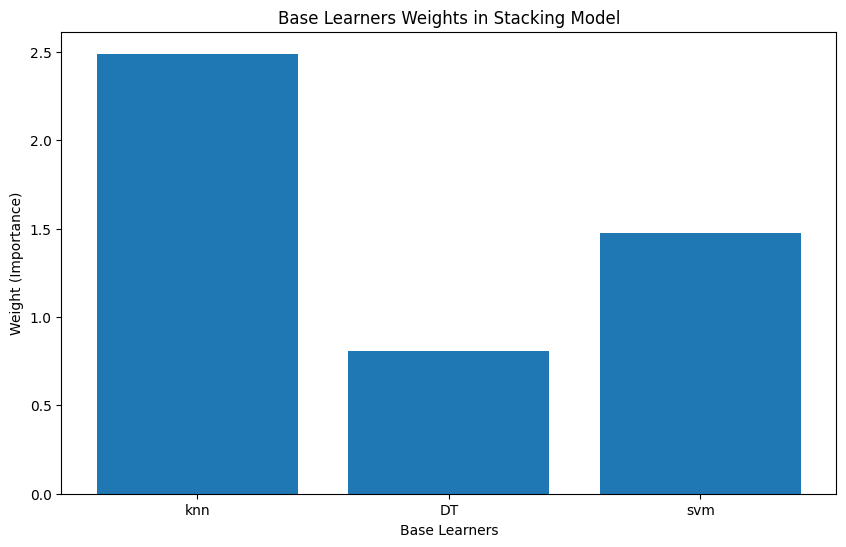

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load the data
train_data = pd.read_csv('gdrive/My Drive/train_data.csv')
test_data = pd.read_csv('gdrive/My Drive/test_data.csv')

# Debugging: Print the shape
print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

# Preprocess the data
X_train = train_data.drop(columns=['Index', 'Bankrupt?'])
y_train = train_data['Bankrupt?']
X_test = test_data.drop(columns=['Index'])

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the stacking model
def get_stacking():
    # Define the base learners
    level0 = list()
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('DT', DecisionTreeClassifier(class_weight='balanced')))
    level0.append(('svm', SVC(class_weight='balanced')))
    # Define the meta learner
    level1 = LogisticRegression(class_weight='balanced')
    # Define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

    return model

stacking_model = get_stacking()

# Evaluate the stacking model using k-fold cross-validation and calculate bias and variance
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_model_accuracies = []
train_bias_squared = []
train_variance = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    stacking_model.fit(X_train_fold, y_train_fold)

    val_predictions = stacking_model.predict(X_val_fold)
    train_predictions = stacking_model.predict(X_train_fold)

    # Calculate accuracy for classification
    accuracy = accuracy_score(y_val_fold, val_predictions)
    meta_model_accuracies.append(accuracy)

    # Calculate bias squared for training set
    train_bias2 = np.mean((y_train_fold - train_predictions) ** 2)

    # Calculate variance for training set
    train_var = np.var(train_predictions)

    train_bias_squared.append(train_bias2)
    train_variance.append(train_var)

# Calculate the average accuracy, bias, and variance across all folds
average_accuracy = np.mean(meta_model_accuracies)
average_train_bias2 = np.mean(train_bias_squared)
average_train_variance = np.mean(train_variance)

print(f'Average Accuracy of the Stacking Meta-Model: {average_accuracy:.4f}')
print(f'Average Train Bias^2: {average_train_bias2:.4f}')
print(f'Average Train Variance: {average_train_variance:.4f}')

# Train the final stacking model on the entire training data
stacking_model.fit(X_train, y_train)

# Predict probabilities for training data
y_prob_train = stacking_model.predict_proba(X_train)[:, 1]

# Adjust the threshold
threshold = 0.96
y_pred_adjusted = (y_prob_train >= threshold).astype(int)

# Evaluate the model with adjusted threshold on the training data
conf_matrix = confusion_matrix(y_train, y_pred_adjusted)
class_report = classification_report(y_train, y_pred_adjusted)

print("Confusion Matrix with Adjusted Threshold:")
print(conf_matrix)
print("\nClassification Report with Adjusted Threshold:")
print(class_report)

# Generate predictions on the test set
test_predictions = stacking_model.predict(X_test)

# Extract and visualize the weights of the base learners
weights = stacking_model.final_estimator_.coef_[0]

plt.figure(figsize=(10, 6))
plt.bar(['knn', 'DT', 'svm'], weights)
plt.xlabel('Base Learners')
plt.ylabel('Weight (Importance)')
plt.title('Base Learners Weights in Stacking Model')
plt.show()

# Generate Submission
submission = pd.DataFrame({
    'Index': test_data['Index'],
    'Bankrupt?': test_predictions
})
submission.to_csv('gdrive/My Drive/submission.csv', index=False)
